In [81]:
# import libraries
import numpy as np
from scipy import signal
import nda.recurrence as rc
import nda.recurrence_quantification as rq
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d import Axes3D

# configure plot appearance
pl.rcParams.update({'font.size': 18, 
                    'lines.linewidth': 1, 
                    'grid.linestyle': ':',
                    'xtick.minor.visible': True,
                    'ytick.minor.visible': True,
                    'font.sans-serif': 'Helvetica'})

In [135]:
# set up function that computes tau-recurrence rate
def rrt(rm, s=1.):
    """
    rrt computes tau-recurrence rate.
    
    Equation from Marwan et al., 2007
    (doi:10.1016/j.physrep.2006.11.001)
    
    Input:
        rm  [recurrence matrix]
    
    Output:
        tau [tau delay]
        rrt [tau-recurrence rate]
    """    
    # length 'n' of data series
    n = len(rm)
    
    # delay 'tau'
    tau = np.arange(-n+1, n)
    
    # tau-recurrence rate 'rrt'
    rrt = []
    
    for t in tau:
        # tau-th diagonal 'd' in the rp
        d = np.diag(rm, k=-t)

        # compute recurrence rate for respective diagonal
        rrt.append(sum(d)/len(d))
        
    return tau*s, rrt

# set up function that computes the power spectrum of a time series
def ps(t, x, s=1, normalize=False):
    """
    ps computes the power spectrum of a time series.
    
    After Mathworks: Power Spectral Density Estimates Using FFT
    (https://de.mathworks.com/help/signal/ug/power-spectral-density-estimates-using-fft.html)
    
    Input:
        t         [time array]
        x         [data array]
        s         [scaling factor, i.e. sampling interval]
        normalize [normalize power spectrum]
    
    Output:
        p         [sampling period]
        ps        [power spectrum]
    """
    # if time array 't' is odd then remove last time point
    if len(t)%2 == 1:
        t = t[:-1]
    
    # time range 'tr'
    tr = t.max()-t.min()
    
    # length 'n' of time series
    n = len(x)

    # derive sampling period 'p'
    p = np.arange(0, tr/2+s, s)
    
    # one-dimensional discrete Fourier transform 'ft'
    ft = np.fft.fft(x)
    ft = ft[:n//2+1]

    # power spectrum 'ps'
    ps = abs(ft)**2
    ps[1:-1] = 2 * ps[1:-1]
    
    if normalize:
        return p, ps/ps.max()
    else:
        return p, ps

# set up function that filters time series
def filt(x, bt, c, fs):
    """    
    filt filters a time series using low-, high-, or band-pass filters.
    
    Input:
        x  [time series]
        bt [filter type, i.e. 'low', 'high', or 'band']
        c  [cutoff(s)]
        fs [sampling frequency]
    
    Output:
        xf [filtered time series]
    """
    # Nyquist frequency 'fn'
    fn = fs * 0.5
    
    # normal cutoff(s) 'cn' and filter order 'o'
    if type(c) == type(0):
        cn = c/fn
        o = 1
    elif type(c) == type([0]):
        cn = [i/fn for i in c]
        o = 5
    
    # filter coefficients 'b' and 'a'
    b,a = signal.butter(o,cn,btype=bt)
    
    # filtered time series 'xf'
    xf = signal.filtfilt(b,a,x)

    return xf

def ac(x, n):
    """
    ac computes the autocorrelation coefficient, i.e. variance-normalized
    autocorrelation, of a time series for a range ot lags.
    
    Input:
        x  [data series]
        n  [number of lags]
    
    Output:
        l  [lags]
        a  [autocorrelation coefficient]
    """
    
    l = np.arange(n)
    a = np.zeros(len(l), dtype='float')
    
    for i, li in enumerate(l):
        if li == 0:
            c = np.cov((x,x))[0,1]
            v = np.var((x,x))
        elif li > 0:
            xo = x[:-li]
            xl = x[li:]
            c = np.cov((xo,xl))[0,1]
            v = np.var((xo,xl))
        a[i] = c/v

    return l, a

# A frequently used climate proxy for the northern-hemisphere climate is NGRIP data. Download the data and preprocess the data if necessary.

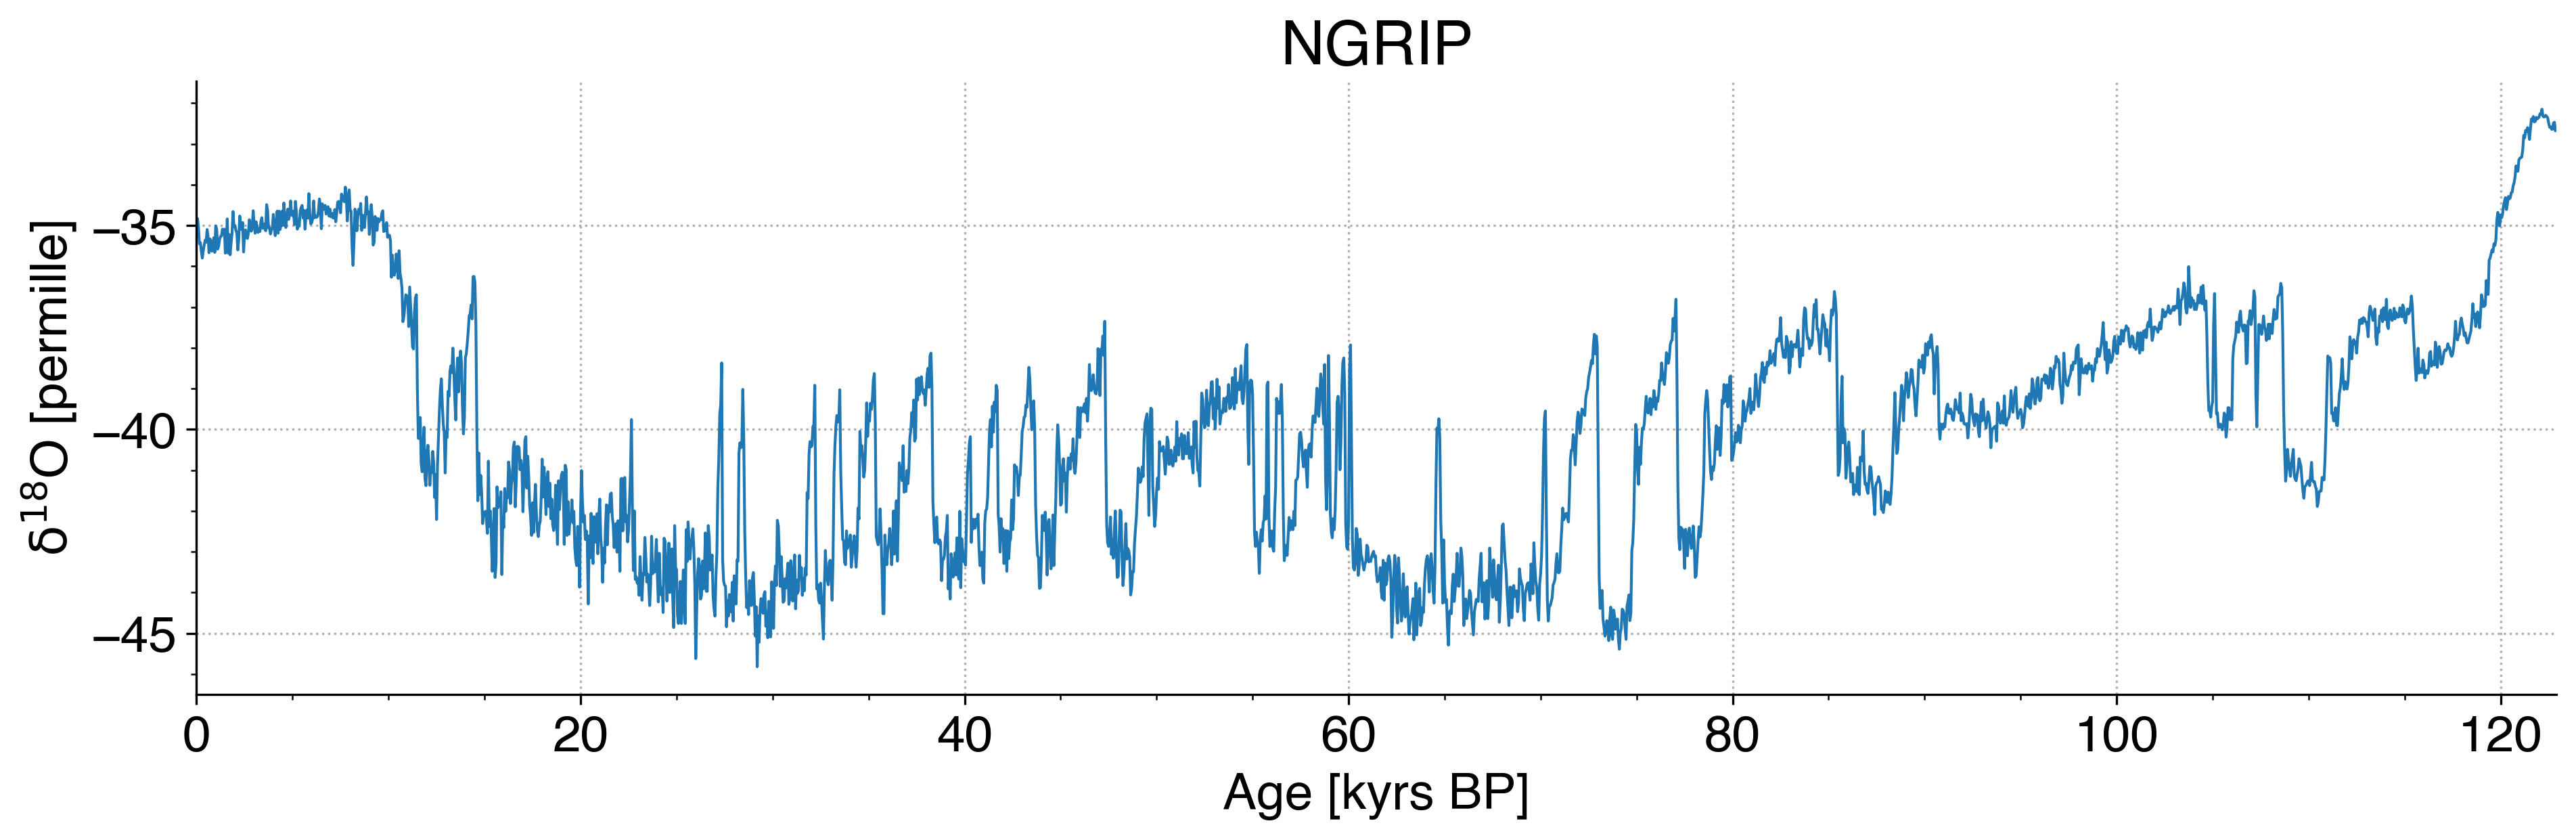

In [3]:
# load data 'd'
d = np.loadtxt('../1_data/41586_2004_BFnature02805_MOESM1_ESM.txt')

# slice data 'd' using every second row
d = d[::2]

# assign variables time 't' [myrs BP] and d18O 'x' [permille]
t = d[:,0]
x = d[:,1]

# remove data 'd' from memory
del(d)

# convert unit of time 't' from [myrs BP] to [kyrs BP]
t /= 1e6

# plot data
pl.figure(figsize=(15,4), dpi=300)
pl.plot(t, x)
pl.xlim(0, t.max())
pl.title('NGRIP')
pl.xlabel('Age [kyrs BP]')
pl.ylabel(r'$\rm\delta^{18}$O [permille]')
pl.gca().spines['top'].set_visible(False)
pl.gca().spines['right'].set_visible(False)
pl.grid();

For filtering the time series using a low- (smooth), high- (detrend), and band-pass filter, it needs to be normalized in advance.

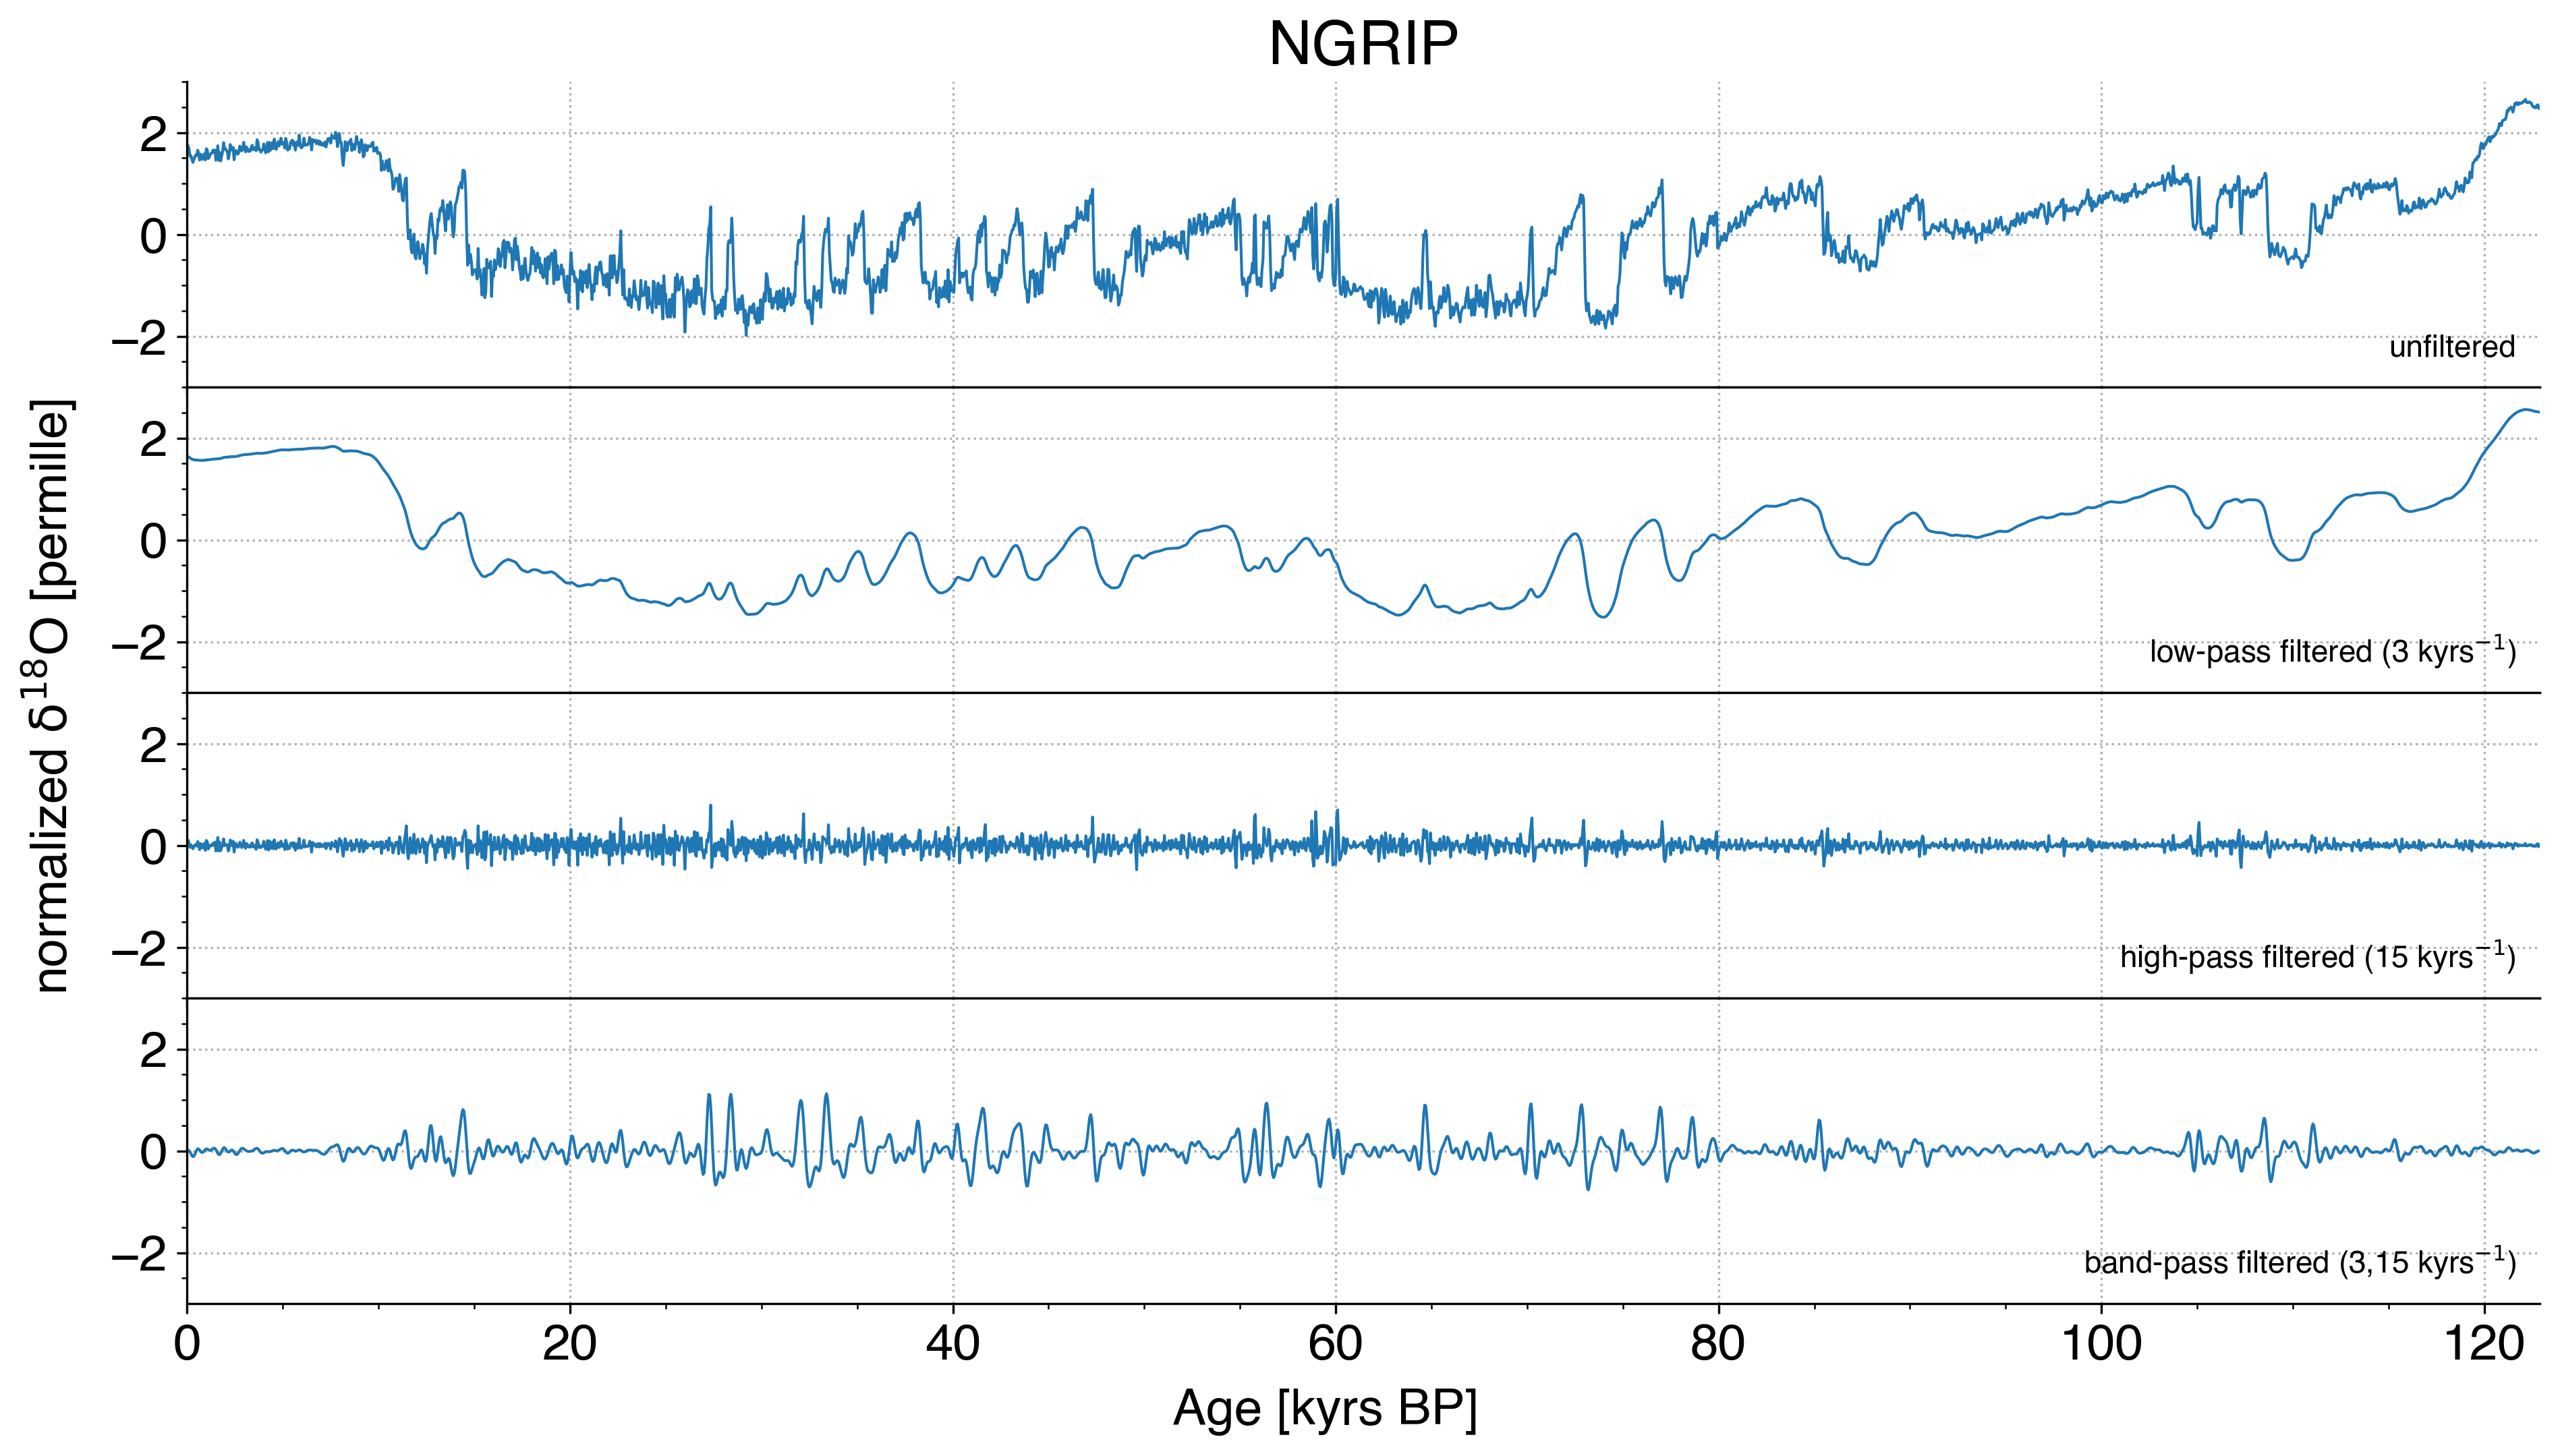

In [4]:
# normalize time series 'x'
x = rc.normalize(x)

# set sampling cutoffs 'sc' [1/kyrs]
sc = [3,15]

# compute sampling frequency 'fs' [1/kyrs]
fs = int(len(x)/t.max())

# compute frequency cutoffs 'fc' [1/kyrs]
fc = [i * fs for i in sc]

# filter time series
x_lp = filt(x, 'low', fc[0], len(x))
x_hp = filt(x, 'high', fc[1], len(x))
x_bp = filt(x, 'band', fc, len(x))

# plot filtered data
fg,ax = pl.subplots(4,1,sharex=True,figsize=(15,8),dpi=300)
pl.subplots_adjust(hspace=0)
ax[0].plot(t, x, label='unfiltered')
ax[0].set_xlim(0,t.max())
ax[0].set_ylim(-3,3)
ax[0].grid()
ax[0].set_title('NGRIP')
ax[0].annotate('unfiltered', (.99,.1), xycoords='axes fraction', horizontalalignment='right', fontsize=11)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].plot(t, x_lp, label='low-pass filtered')
ax[1].set_ylim(-3,3)
ax[1].grid()
ax[1].annotate(r'low-pass filtered (%s kyrs$^{-1}$)' %sc[0], (.99,.1), xycoords='axes fraction', horizontalalignment='right', fontsize=11)
ax[1].spines['right'].set_visible(False)
ax[2].plot(t, x_hp, label='high-pass filtered')
ax[2].set_ylim(-3,3)
ax[2].grid()
ax[2].annotate(r'high-pass filtered (%s kyrs$^{-1}$)' %sc[1], (.99,.1), xycoords='axes fraction', horizontalalignment='right', fontsize=11)
ax[2].spines['right'].set_visible(False)
ax[3].plot(t, x_bp, label='band-pass filtered')
ax[3].set_ylim(-3,3)
ax[3].grid()
ax[3].annotate(r'band-pass filtered (%s,%s kyrs$^{-1}$)' %(sc[0],sc[1]), (.99,.1), xycoords='axes fraction', horizontalalignment='right', fontsize=11)
ax[3].spines['right'].set_visible(False)
fg.text(0.5, 0.05, 'Age [kyrs BP]', ha='center')
fg.text(0.07, 0.5, r'normalized $\rm\delta^{18}$O [permille]', va='center', rotation='vertical');

# Estimate embedding parameters and reconstruct and present the phase space trajectory.

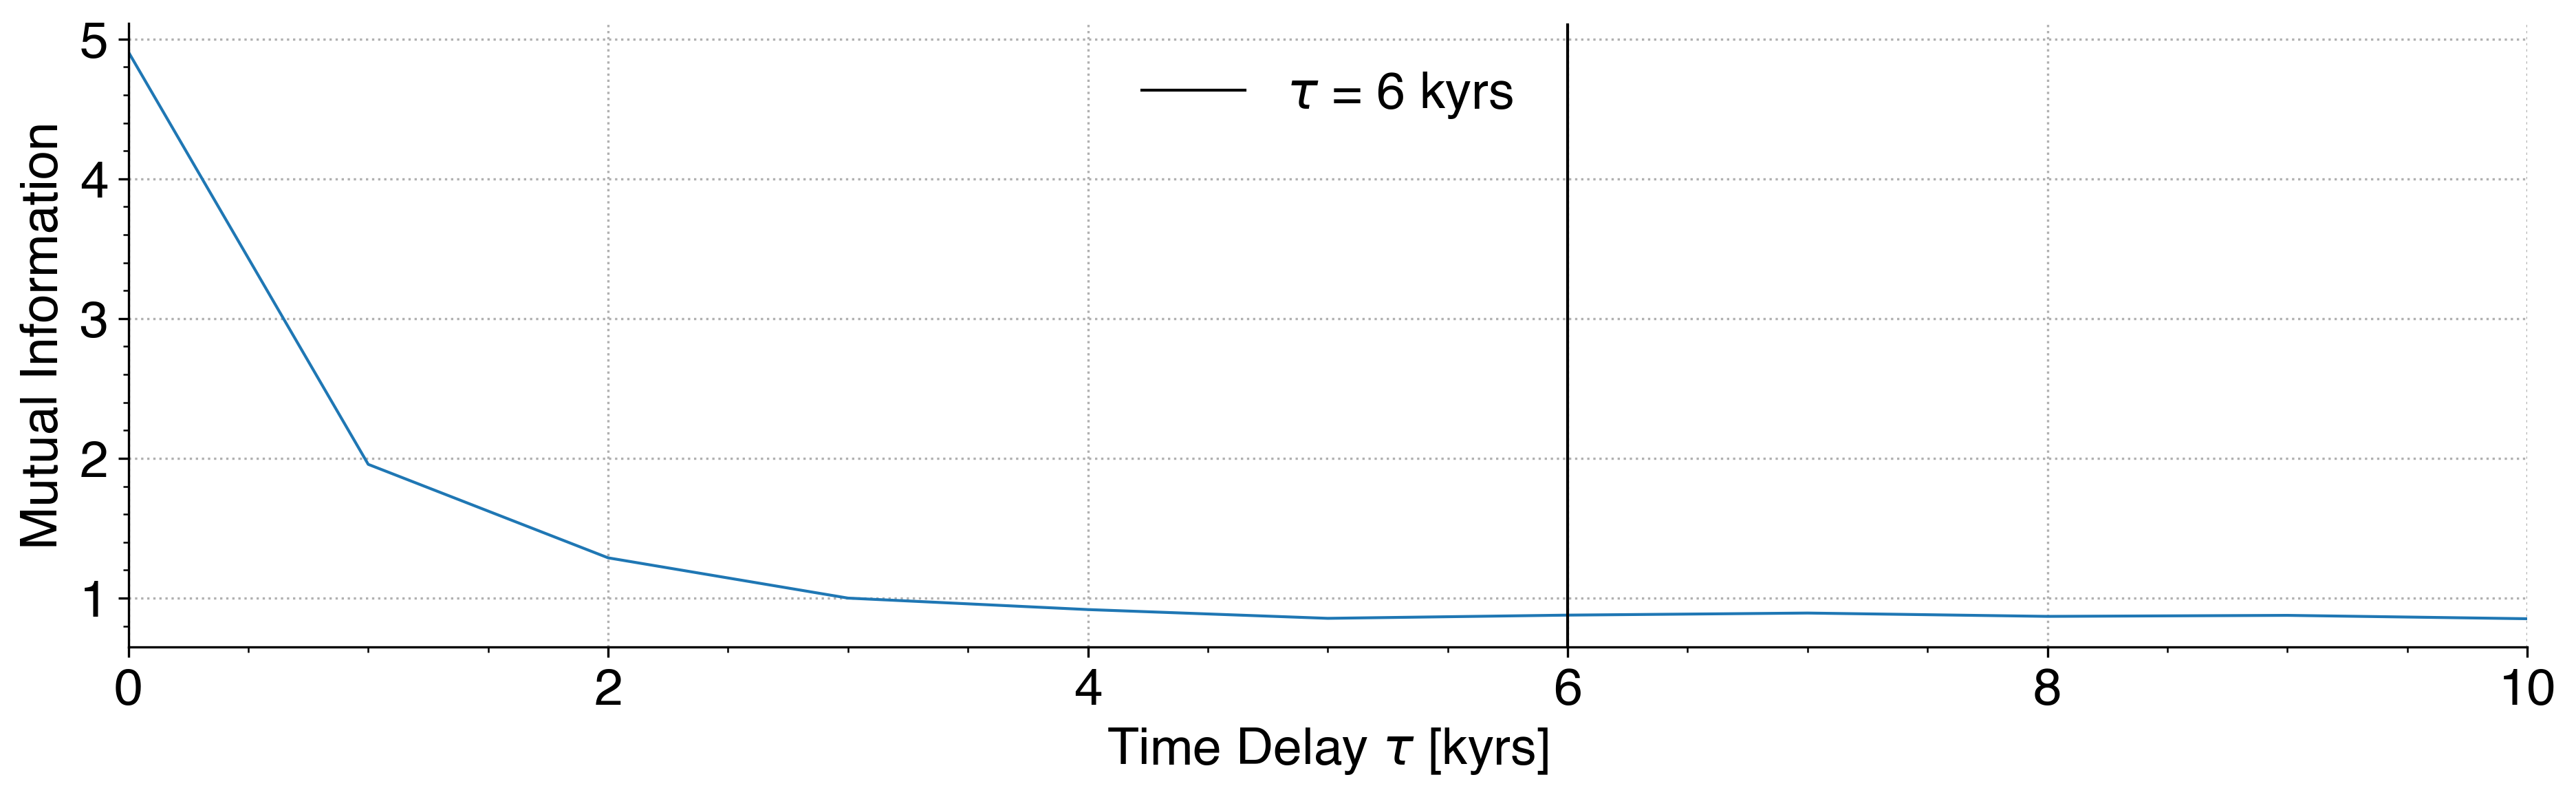

In [117]:
# calculate mutual information 'mi' per time delays 'taus'
mi, taus = rc.mi(x_bp, 11)

# estimate time delay 'tau'
tau = rc.first_minimum(mi)

# plot mutual information
pl.figure(figsize=(15,4), dpi=300)
pl.plot(taus, mi)
pl.axvline(tau, c='k', label=r'$\tau$ = %s kyrs' %tau)
pl.xlim(0, taus.max())
pl.xlabel(r'Time Delay $\tau$ [kyrs]')
pl.ylabel('Mutual Information')
pl.legend(loc='upper center', frameon=False)
pl.gca().spines['top'].set_visible(False)
pl.gca().spines['right'].set_visible(False)
pl.grid();

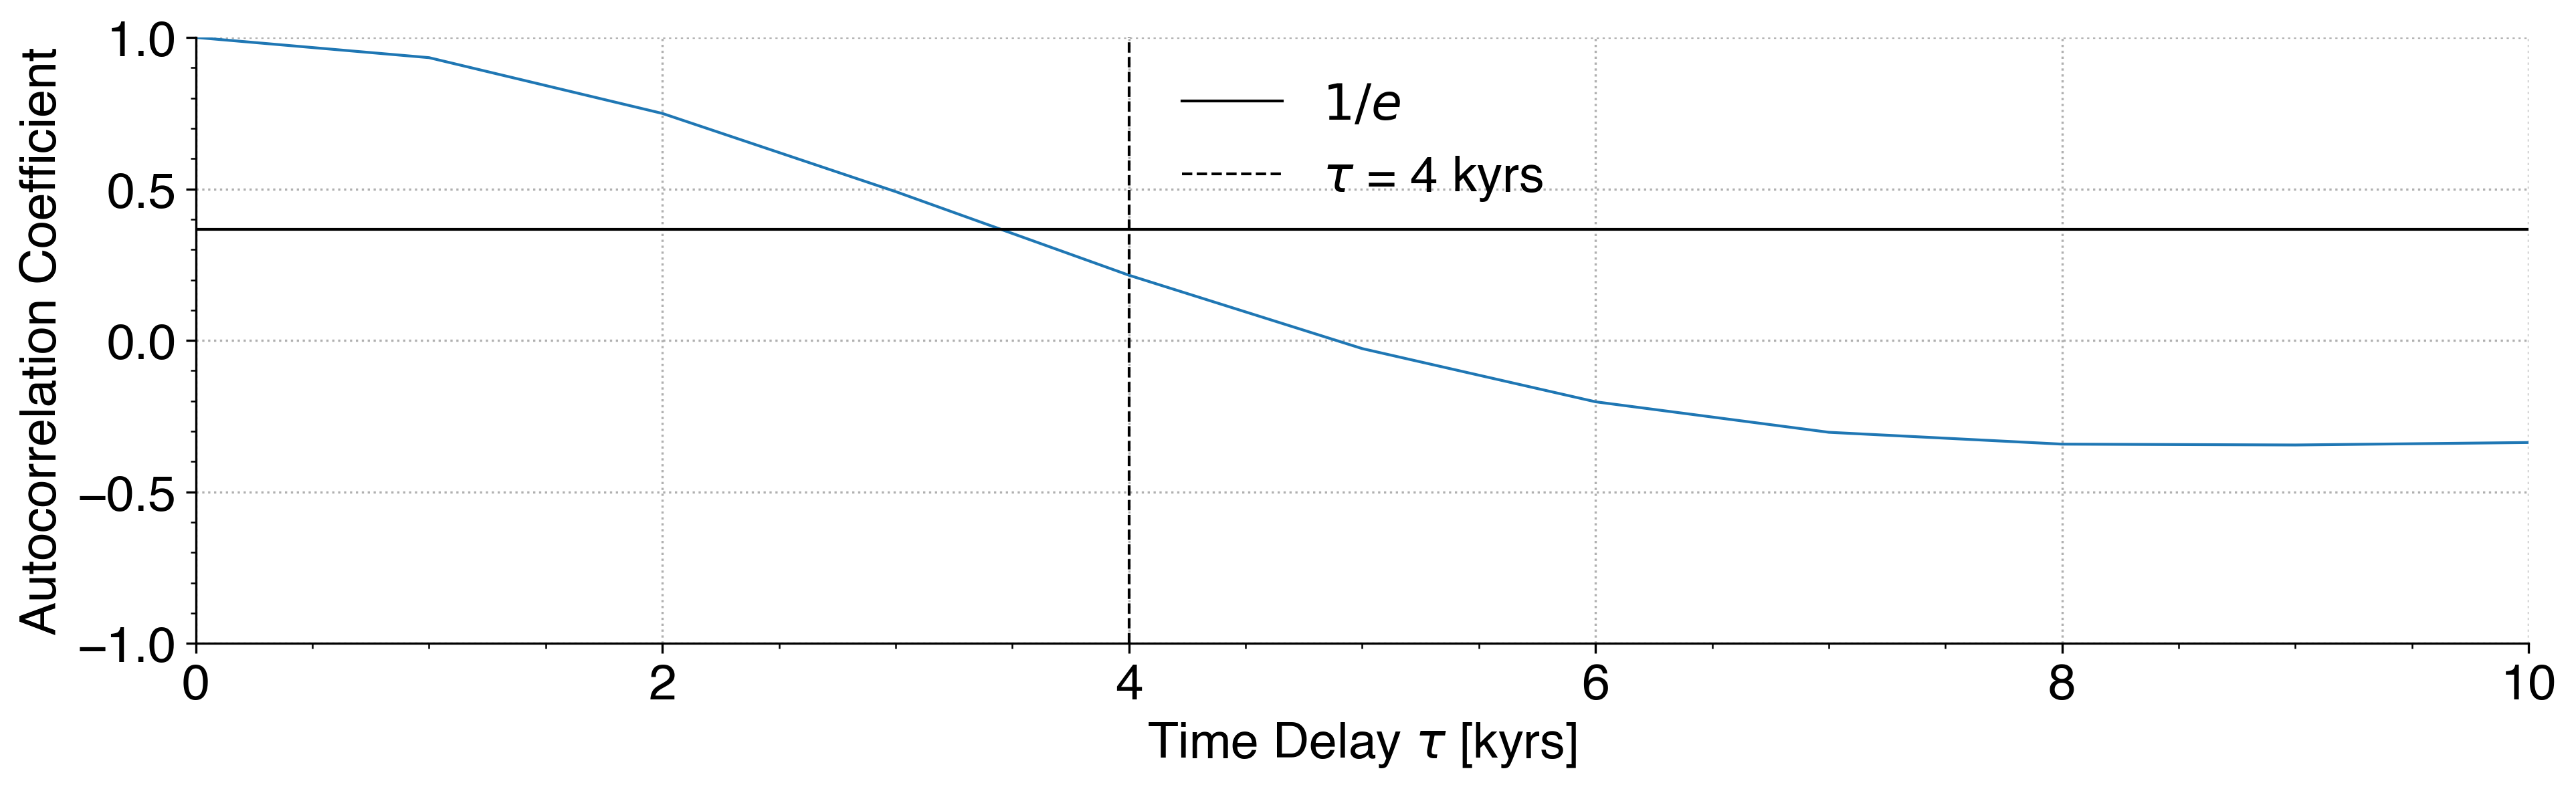

In [118]:
# compute variance-normalized auto-correlation of the time series 'x_ac'
# for a lag range 'l'
l, x_ac = ac(x_bp, 11)

# compute 1/e, where e is the Euler number
ooe = 1/np.exp(1)

# derive time delay 'tau', i.e. the delay after which the autocorrelation
# coefficient of the time series 'x_ac' is less than 1/e
tau = l[x_ac<ooe][0]

# plot variance-normalized autocorrelation of the time series
pl.figure(figsize=(15,4), dpi=300)
pl.plot(l,x_ac)
pl.axhline(ooe, c='k', label=r'$1/e$')
pl.axvline(tau, c='k', linestyle='--', label=r'$\tau$ = %i kyrs' %tau)
pl.xlim(0, l.max())
pl.ylim(-1,1)
pl.xlabel(r'Time Delay $\tau$ [kyrs]')
pl.ylabel('Autocorrelation Coefficient')
pl.legend(loc='upper center', frameon=False)
pl.gca().spines['top'].set_visible(False)
pl.gca().spines['right'].set_visible(False)
pl.grid();

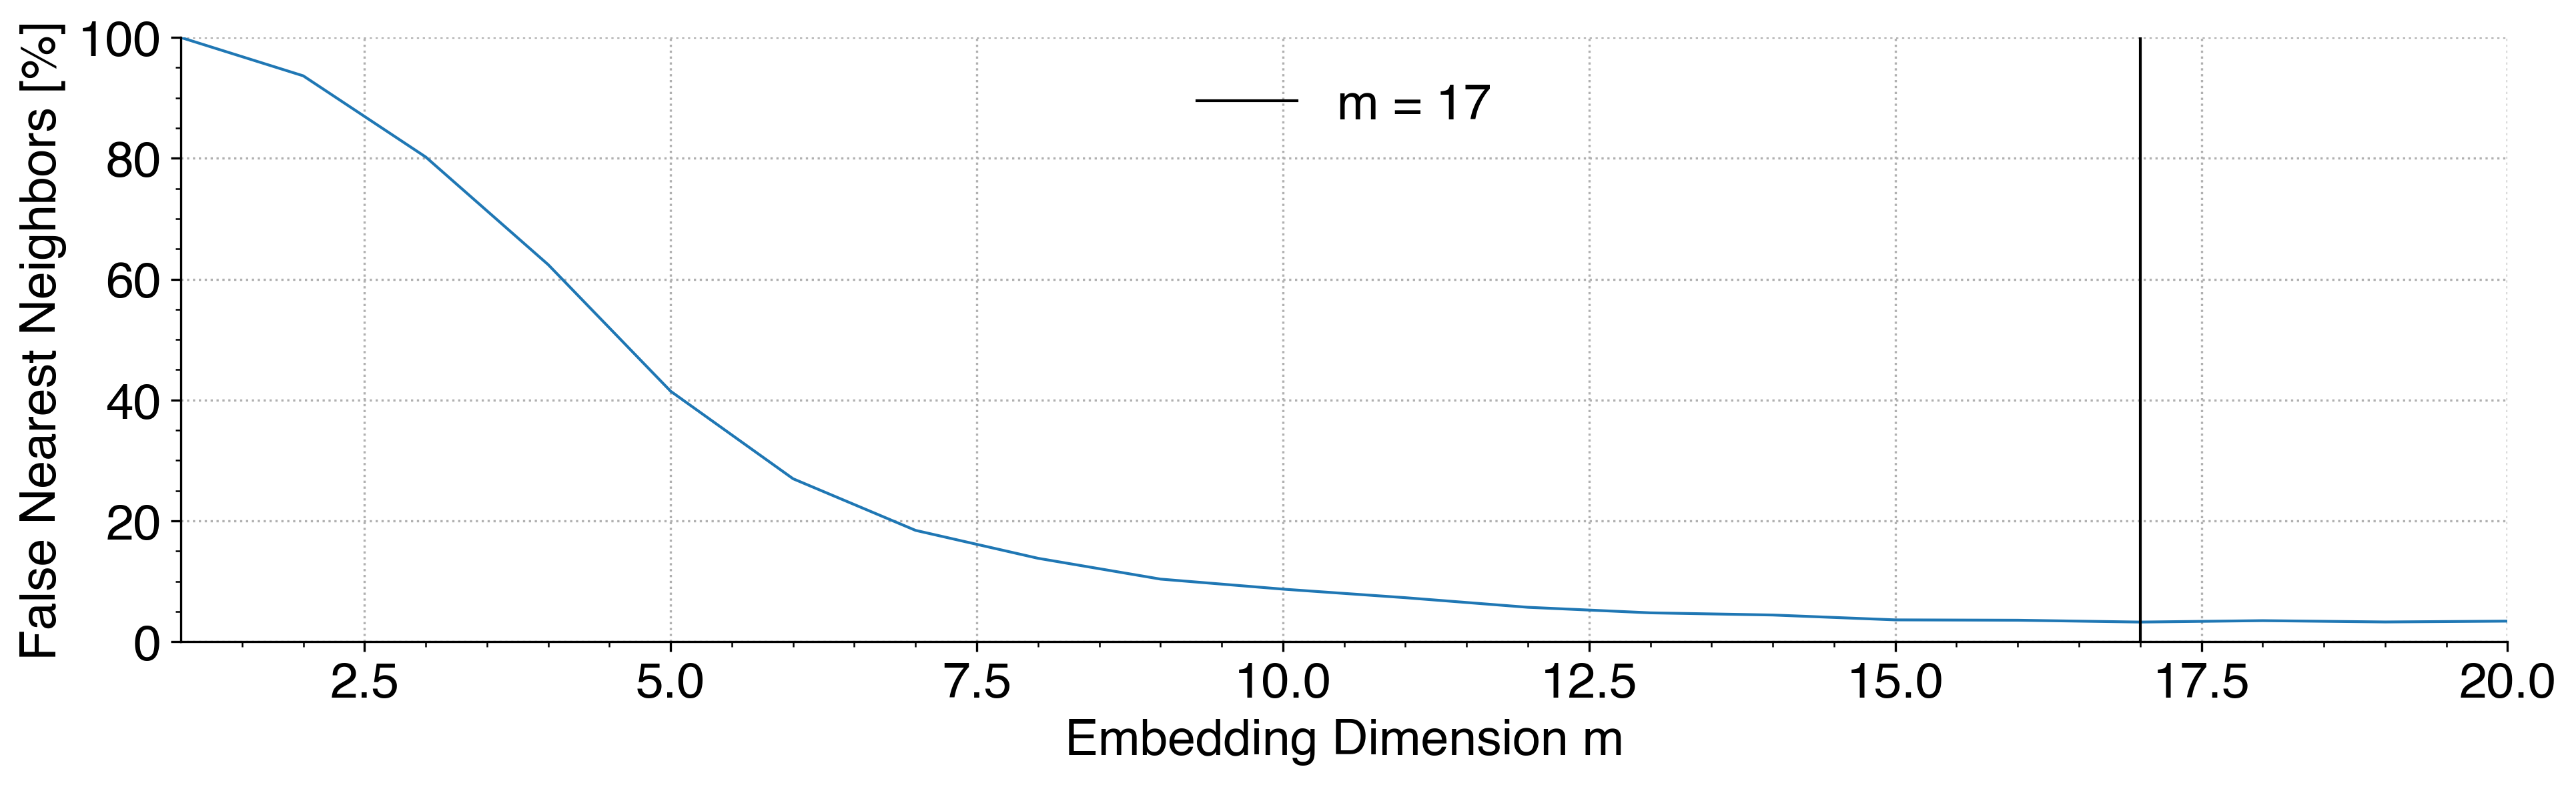

In [120]:
# calculate fraction of false nearest neighbors 'fn' per embedding dimensions 'ms'
fn, ms = rc.fnn(x_bp, tau, 20, r=1)

# estimate suitable embedding dimension 'm'
m = rc.first_minimum(fn)

# plot mutual information
pl.figure(figsize=(15,4), dpi=300)
pl.plot(ms, fn*100)
pl.axvline(m, c='k', label='m = ' + str(m))
pl.xlim(1, ms.max())
pl.ylim(0, 100)
pl.xlabel('Embedding Dimension m')
pl.ylabel(r'False Nearest Neighbors [%]')
pl.legend(loc='upper center', frameon=False)
pl.gca().spines['top'].set_visible(False)
pl.gca().spines['right'].set_visible(False)
pl.grid();

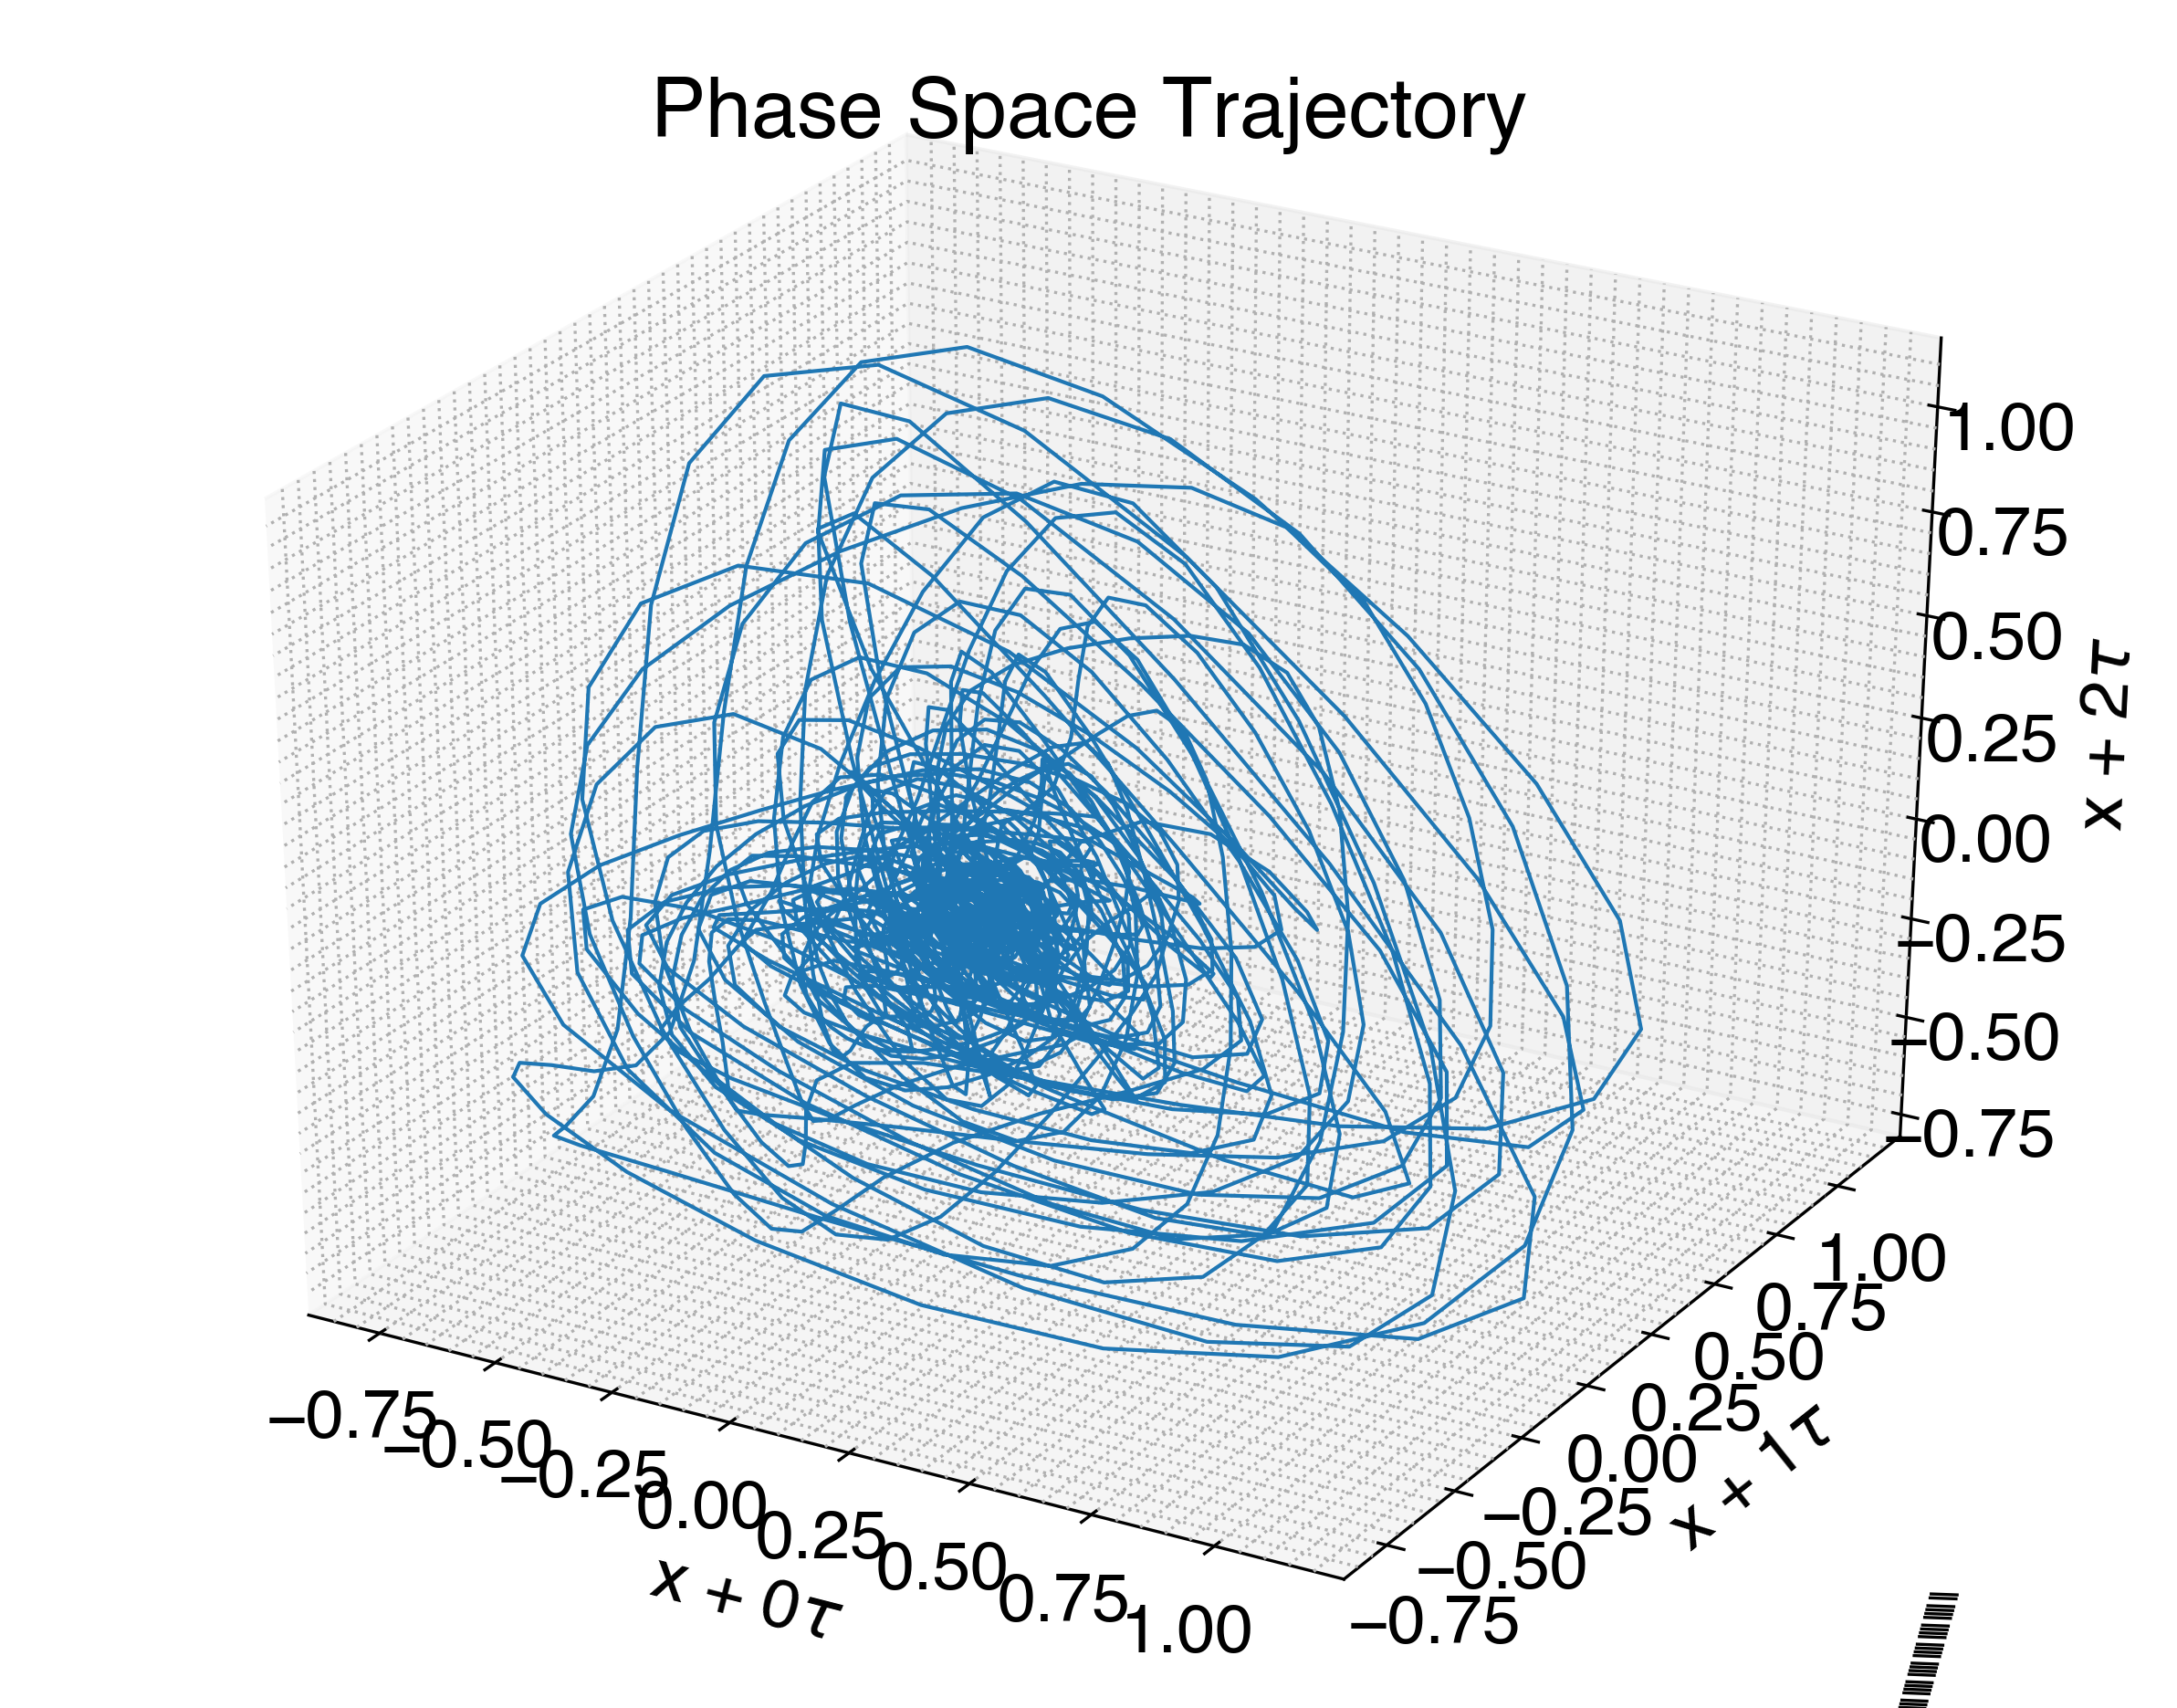

In [121]:
# embed the time series 'xe'
xe = rc.embed(x_bp, m, tau)

# plot first 3 dimensions of phase space trajectory
pl.figure(figsize=(10,8), dpi=300)
ax = pl.gca(projection='3d')
ax.plot(xe[:,0], xe[:,1], xe[:,2])
ax.set_title('Phase Space Trajectory')
ax.set_xlabel('\n' + r'x + 0$\tau$')
ax.set_ylabel('\n' + r'x + 1$\tau$')
ax.set_zlabel('\n' + r'x + 2$\tau$');

# Construct a RP of this embedded time series. Check different options of recurrence criteria and discuss your final choice. Interpret the visual appearance of the RP.

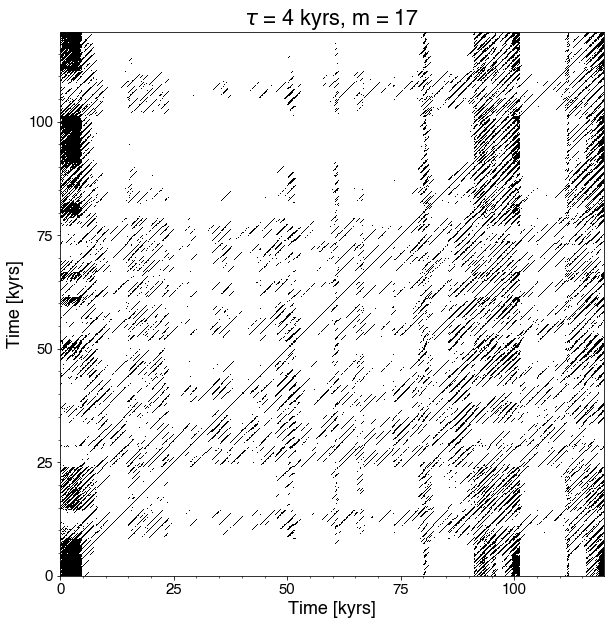

In [122]:
# derive recurrence matrix 'rm'
rm = rc.rp(x, m, tau, 0.1, threshold_by='fan')

# derive recurrence matrix 'rm' for filtered time series
rm_lp = rc.rp(x_lp, m, tau, 0.1, threshold_by='fan')
rm_hp = rc.rp(x_hp, m, tau, 0.1, threshold_by='fan')
rm_bp = rc.rp(x_bp, m, tau, 0.1, threshold_by='fan')

# plot recurrence plot
pl.figure(figsize=(10,10))
pl.imshow(rm_bp, cmap='binary', origin='lower')
pl.title(r'$\tau$ = %s kyrs, m = %s' %(tau, m))
ax_is = pl.gca().get_xticks()[1:-1]
ax_be = [int(ax_is[i] * 50 * 1e-3) for i in range(len(ax_is))]
pl.gca().set_xticks(ax_is)
pl.gca().set_xticklabels(ax_be, fontsize=15)
pl.gca().set_xlabel('Time [kyrs]');
pl.gca().set_yticks(ax_is)
pl.gca().set_yticklabels(ax_be, fontsize=15)
pl.gca().set_ylabel('Time [kyrs]');

# Compute the τ-recurrence rate as a function of τ and display the results. Check different filtering options (low-pass, high-pass, band-pass filter) and their impact on the τ-recurrence rate.

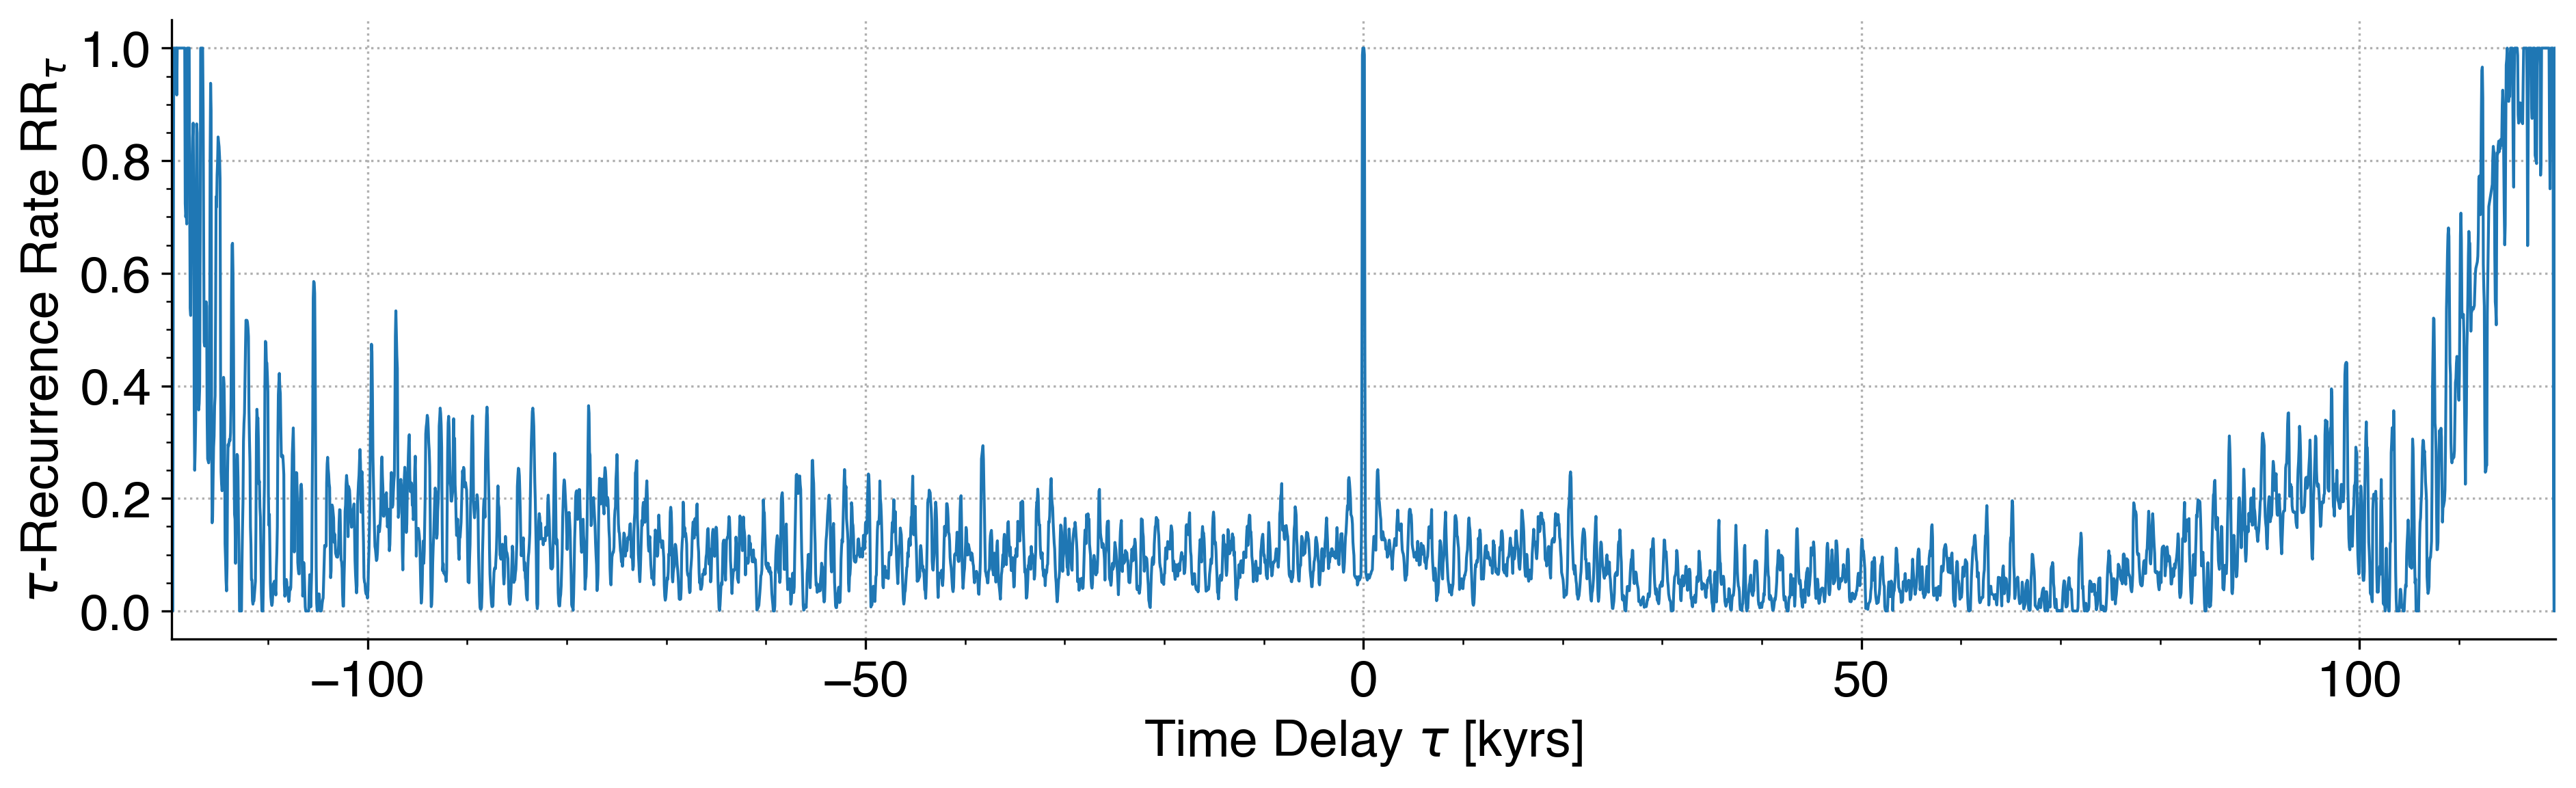

In [123]:
# compute tau-recurrence rate 'rr' as a function of tau 'rt'
rt, rr = rrt(rm, 50*1e-3)
rt, rr = rrt(rm_bp, 50*1e-3)

# plot tau-recurrence rate
pl.figure(figsize=(15,4), dpi=300)
pl.plot(rt, rr)
pl.xlim(rt.min(), rt.max())
pl.xlabel(r'Time Delay $\tau$ [kyrs]')
pl.ylabel(r'$\tau$-Recurrence Rate RR$_\tau$')
pl.gca().spines['top'].set_visible(False)
pl.gca().spines['right'].set_visible(False)
pl.grid();

# Make a fourier transform of all the τ-recurrence rate and show the squared absolute values of these transforms as a function of the sampling period (recurrence based powerspectrum).

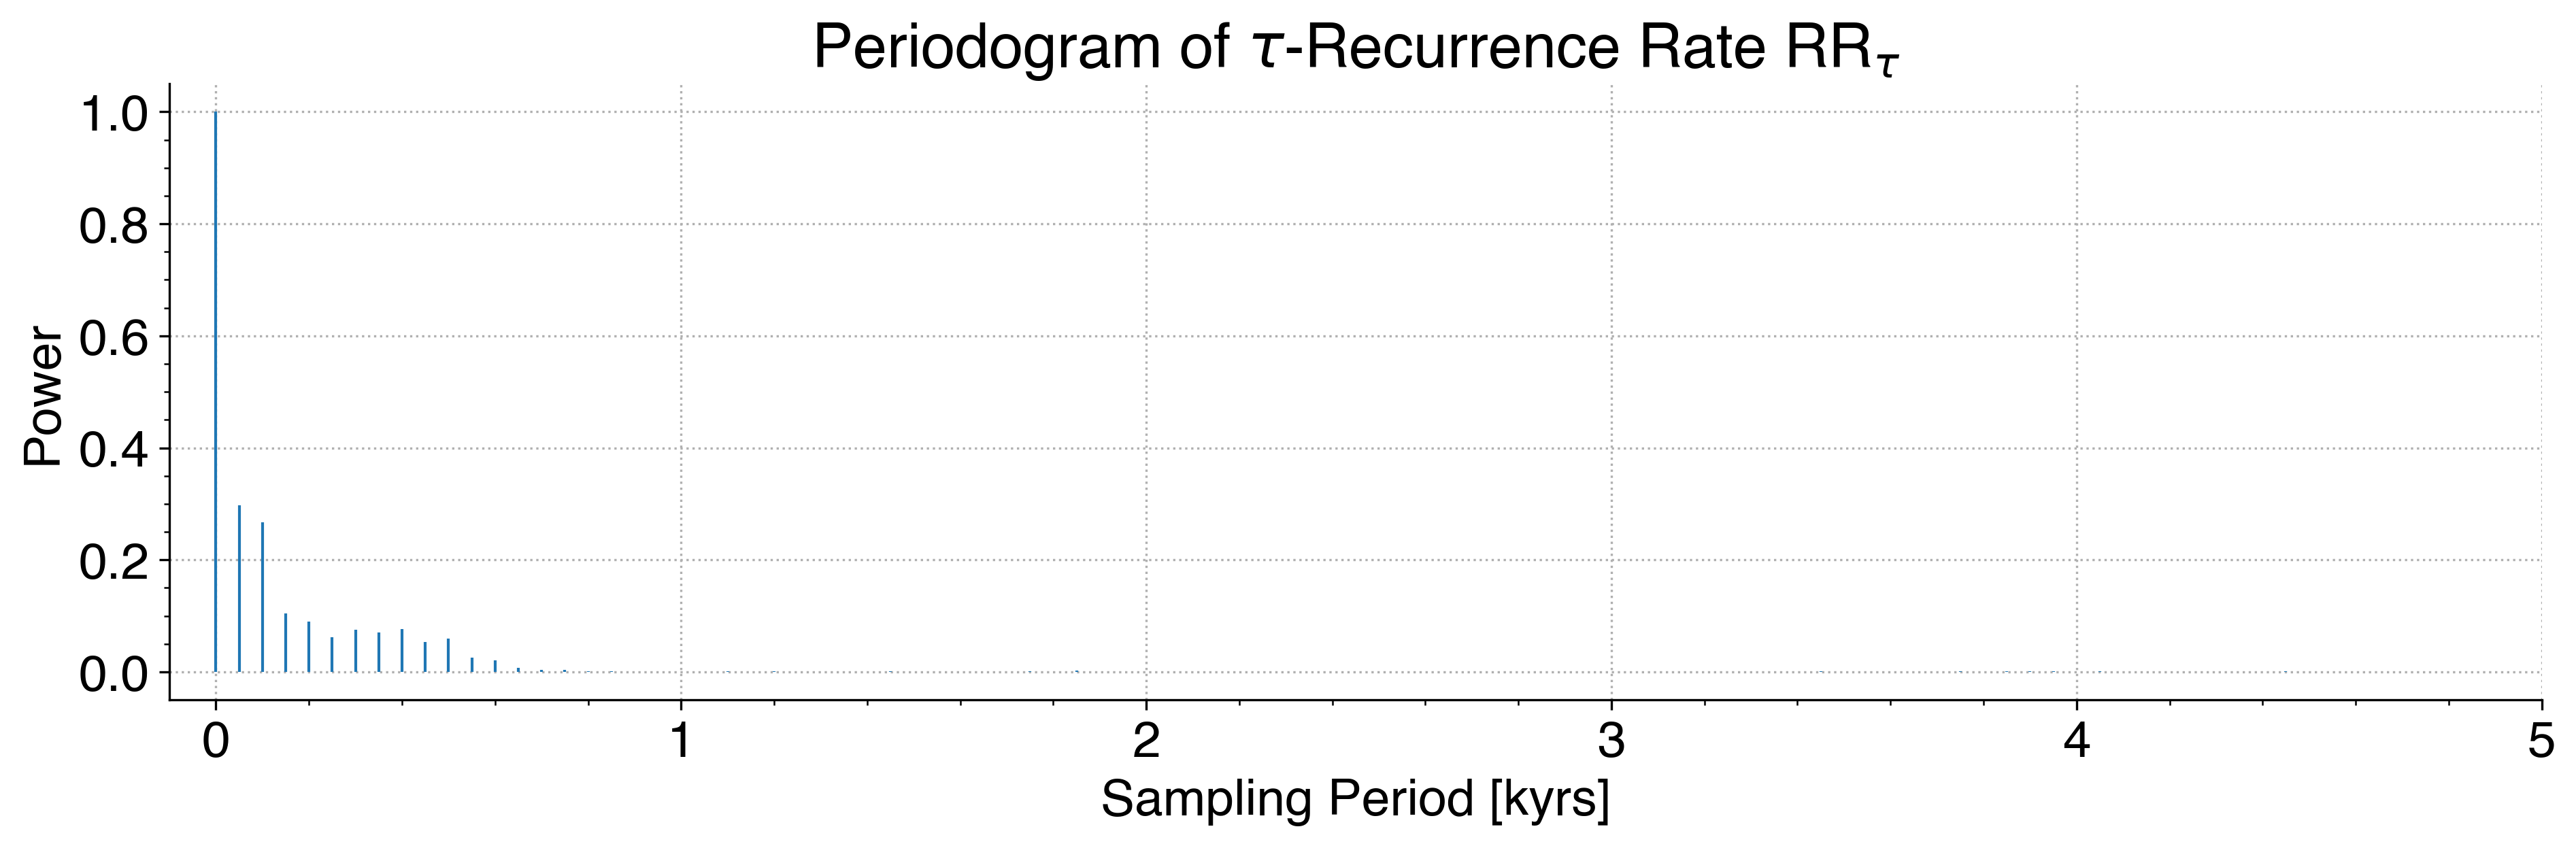

In [136]:
# compute power spectrum of tau-recurrence rate 'pse'
# for different sampling periods 'pe'
pe, pse = ps(rt, rr, 50 * 1e-3, normalize=True)

# plot power spectrum of tau-recurrence rate
pl.figure(figsize=(15,4), dpi=300)
pl.stem(pe, pse, markerfmt=' ', basefmt=' ', use_line_collection=True)
pl.xlim(-.1, 5)
pl.title(r'Periodogram of $\tau$-Recurrence Rate RR$_\tau$')
pl.xlabel('Sampling Period [kyrs]')
pl.ylabel('Power')
pl.gca().spines['top'].set_visible(False)
pl.gca().spines['right'].set_visible(False)
pl.grid();

# Make a Fourier Analysis of the original time series and compare and discuss the powerspectrum with the recurrence based powerspectrum.

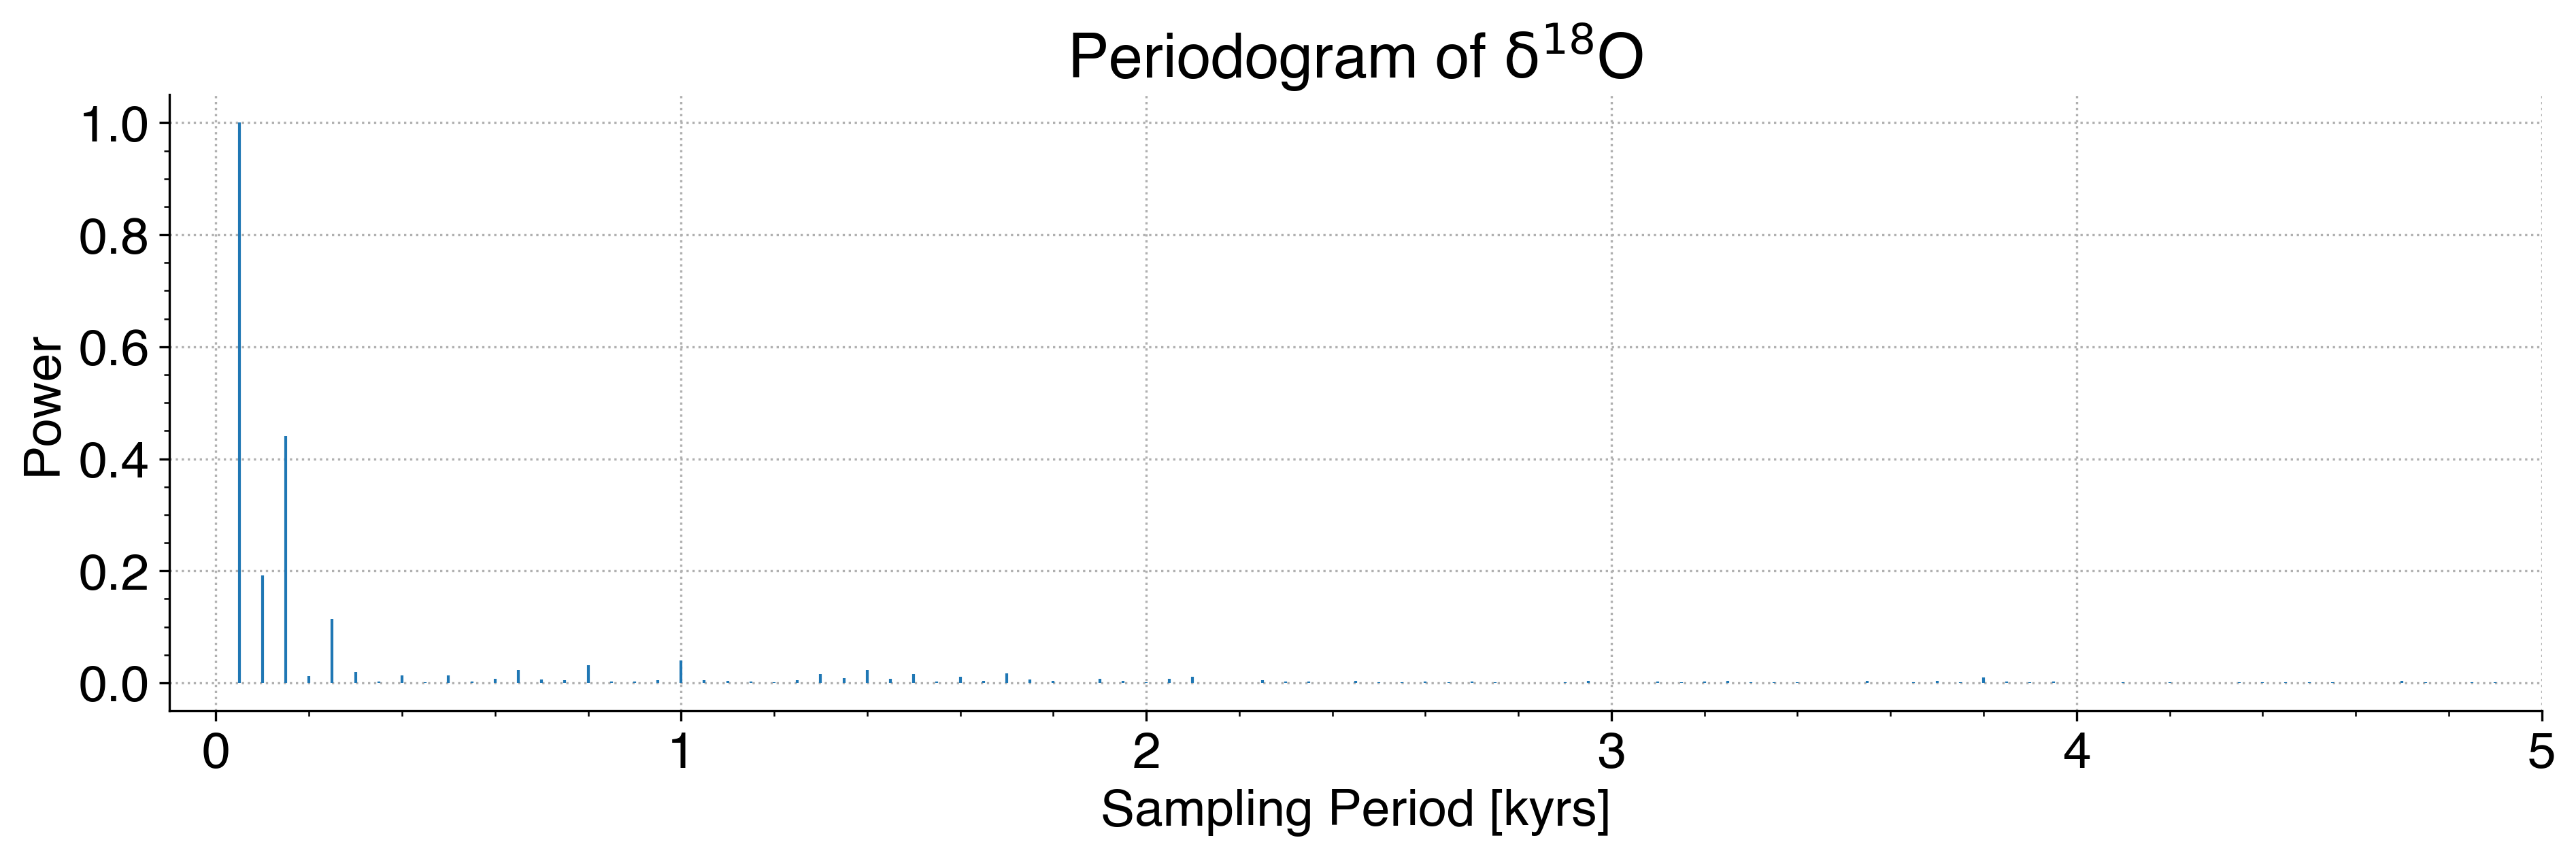

In [137]:
# compute power spectrum of tau-recurrence rate 'psx'
# for different sampling periods 'px'
px, psx = ps(t, x, 50 * 1e-3, normalize=True)

# plot power spectrum of tau-recurrence rate
pl.figure(figsize=(15,4), dpi=300)
pl.stem(px, psx, markerfmt=' ', basefmt=' ', use_line_collection=True)
pl.xlim(-.1, 5)
pl.title(r'Periodogram of $\rm\delta^{18}$O')
pl.xlabel('Sampling Period [kyrs]')
pl.ylabel('Power')
pl.gca().spines['top'].set_visible(False)
pl.gca().spines['right'].set_visible(False)
pl.grid();

# References {-}

Andersen, K., Azuma, N., Barnola, J. et al. High-resolution record of Northern Hemisphere climate extending into the last interglacial period. Nature 431, 147–151 (2004). https://doi.org/10.1038/nature02805